# Signal Analysis
October 11, 2022
***
## Overview
Let's take a look at some possible indicators to signal what business cycle we are in. Recall, our cycles are:

1. Expansion
2. Slowdown
3. Contraction
4. Recovery

There are 2 tasks to look at here.

1. We need to figure out what business cycle we are in and when. This is where the whole clustering idea fits in - we want labels. **It might not work.** The clustering idea is as follows,
    - Take certain macroeconomic indicators, feed them to pipeline of PCA and clustering (ideally $n=4$ clusters), and see if we get some commonalities. These clusters will serve as generated labels. We should also check out time-series clustering.
2. We also need to verify these labels correlate with robust factor performance. We have already perfomed a pretty robust exploratory data analysis of factor returns, we might be able to build off that as well.

__[Factors](https://www.blackrock.com/us/individual/investment-ideas/what-is-factor-investing)__

In [1]:
import warnings
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import scipy as sp
import statsmodels as sm
import scipy.stats as spstat
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import quandl as q
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from support import fama_french, set_first
from fredapi import Fred
fred = Fred(api_key="11ae3d2ef9363b6c65ce74df68755758")
plt.style.use("ggplot")


## Indicators
Let's take a look at some various indicators from FRED.

In [3]:
# # Individual Plots

# # University of Michigan: Consumer Sentiment
# var = "UMCSENT"
# umcs = fred.get_series(var, observation_start="1978")
# umcs = pd.DataFrame(umcs)
# umcs.index = pd.to_datetime(umcs.index)
# # Continuous since 1978, 1966 Q1 = 100, need to reset to 1978-01-01
# umcs.index.name = "Date"
# umcs.columns = ["UMCSENT"]
# umcs["Ret"] = umcs["UMCSENT"].pct_change()
# umcs["CRet"] = (umcs["Ret"] + 1).cumprod() - 1
# umcs["UMCSENT"] = 1 * umcs["CRet"] + 1
# umcs.iloc[0,0] = 1

# # Now we have it starting from the start date at 1, along with pct_change and cumulative pct_change
# fig = px.line(umcs["UMCSENT"], title="University of Michigan: Consumer Sentiment")

# for start, end in zip(start_rec, end_rec):
#     if pd.to_datetime(end) > umcs.index.min():
#         fig.add_vrect(x0=start, x1=end, fillcolor="grey", opacity=0.5, line_width=0)
# # fig.show()

# # Chicago Fed National Financial Conditions Index
# var = "NFCI"
# nfci = fred.get_series(var)

# fig = px.line(nfci, title="Chicago Fed National Financial Conditions Index")

# for start, end in zip(start_rec, end_rec):
#     if pd.to_datetime(end) > nfci.index.min():
#         fig.add_vrect(x0=start, x1=end, fillcolor="grey", opacity=0.5, line_width=0)
# # fig.show()

# # St. Louis Fed Financial Stress Index
# var = "STLFSI3"
# slfsi = fred.get_series(var)

# fig = px.line(slfsi, title="St. Louis Fed Financial Stress Index")

# for start, end in zip(start_rec, end_rec):
#     if pd.to_datetime(end) > slfsi.index.min():
#         fig.add_vrect(x0=start, x1=end, fillcolor="grey", opacity=0.5, line_width=0)
# # fig.show()

In [2]:
# some indexes make it tricky, might just want to get MoM change and then plot cumulative

def csi(since_y="1978"):
    # Get UM Consumer Sentiment as cumulative return from since_y
    # Continuous since 1978, 1966 Q1 = 100, need to reset to 1978-01-01
    df = pd.DataFrame(fred.get_series("UMCSENT", observation_start=since_y), columns=["UMCSENT"])
    df = df.resample("M").last().to_period("M")
    df.index = pd.to_datetime(df.index.to_timestamp())
    return ((df.pct_change() + 1).cumprod() - 1).dropna() + 1

def cnfci():
    # Get Chicago Fed National Financial Conditions Index
    df = pd.DataFrame(fred.get_series("NFCI"), columns=["NFCI"])
    df = df.resample("M").last().to_period("M")
    df.index = pd.to_datetime(df.index.to_timestamp())
    return df

def slfsi():
    # Get St. Louis Fed Financial Stress Index
    df = pd.DataFrame(fred.get_series("STLFSI3"), columns=["STLFSI3"])
    df = df.resample("M").last().to_period("M")
    df.index = pd.to_datetime(df.index.to_timestamp())
    return df

def cpi(since_y="1971"):
    # Get Consumer Price Index as cumulative return from since_y
    df = pd.DataFrame(fred.get_series("CPIAUCSL", observation_start=since_y), columns=["CPIAUCSL"])
    df = df.resample("M").last().to_period("M")
    df.index = pd.to_datetime(df.index.to_timestamp())
    return ((df.pct_change() + 1).cumprod() - 1).dropna() + 1

def hys():
    # High yield spread
    df = pd.DataFrame(fred.get_series("BAMLH0A0HYM2"), columns=["BAMLH0A0HYM2"])
    df = df.resample("M").last().to_period("M")
    df.index = pd.to_datetime(df.index.to_timestamp())
    return df


In [3]:
# Dates of U.S. recessions as inferred by GDP-based recession indicator
var = "JHDUSRGDPBR"
rec = pd.DataFrame(fred.get_series(var), columns=["Rec"])

start_rec = [i.strftime("%Y-%m-%d") for i in rec[(rec["Rec"] == 1) & (rec["Rec"].shift(1) == 0) & (rec["Rec"].shift(-1) == 1)].index.date]
end_rec = [i.strftime("%Y-%m-%d") for i in rec[(rec["Rec"] == 1) & (rec["Rec"].shift(-1) == 0) & (rec["Rec"].shift(1) == 1)].index.date]

# fig = px.line(rec, title="Dates of U.S. recessions as inferred by GDP-based recession indicator")
# Shade Recession Code
# for start, end in zip(start_rec, end_rec):
    # fig.add_vrect(x0=start, x1=end, fillcolor="grey", opacity=0.5, line_width=0)
# fig.show()

In [4]:
data = pd.concat([cnfci(), csi(), slfsi(), cpi(), hys()], axis=1)
data = data.dropna()
fig = px.line(data)
for start, end in zip(start_rec, end_rec):
    if pd.to_datetime(end) > data.index.min():
        fig.add_vrect(x0=start, x1=end, fillcolor="grey", opacity=0.5, line_width=0)
fig.show()

## Reverse Engineering Labels from Factors

Test this by first looking at the variance each principal component explains. We will use PCA to reduce data $\mathbf{X}\in\mathbb{R}^{n\times2}$.

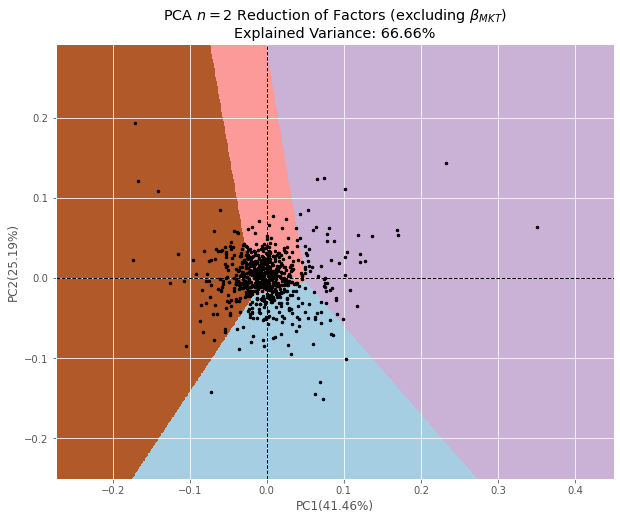

In [5]:
ff = fama_french()
ff = ff.drop(["Mkt_RF", "RF"], axis=1)

pca = PCA(n_components=2)
red_ff = pca.fit_transform(ff)

kmeans = KMeans(n_clusters=4)
kmeans.fit(red_ff)

# Mesh step size, lower for better quality
h = 0.001

# Buffer for min/max
buff = 0.1

x_min, x_max = red_ff[:, 0].min() - buff, red_ff[:, 0].max() + buff
y_min, y_max = red_ff[:, 1].min() - buff, red_ff[:, 1].max() + buff
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
plt.axvline(x=0, color="black", linewidth=1, linestyle="--")
plt.plot(red_ff[:, 0], red_ff[:, 1], "k.", markersize=5)
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.2f}%)")
total_var = pca.explained_variance_ratio_.sum()*100
t = r"PCA $n=2$ Reduction of Factors (excluding $\beta_{MKT}$)" + f"\nExplained Variance: {total_var:.2f}%"
plt.title(t)
plt.show()

Reduction to 2 dimensional data does not explain a lot of the variance. This makes sense because factors are meant to diversify risk away. Thus, PCA might not be applicable or necessary. While were here, lets see what the mean performance is by factor (disregarding market factor).

In [12]:
for i in range(1, 6):
    print("*"*40)
    print(f"PCA {i}-components")

    ff = fama_french()
    ff = ff.drop(["Mkt_RF", "RF"], axis=1)

    pca = PCA(n_components=i)
    red_ff = pca.fit_transform(ff)
    print(f"Explained Variances: {pca.explained_variance_ratio_.round(2)}")
    print(f"Explained Variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(red_ff)

    ff["Label"] = kmeans.predict(red_ff)

    res = (ff.groupby("Label").mean() * 100).style.highlight_max(color='green', axis=1).highlight_min(color='red', axis=1).format("{:.2f}")
    display(res)
    # display(ff.groupby("Label").describe().T) Too much info
    display(ff.groupby("Label").agg(['mean', 'var', 'count']).round(4))
    # print(ff.groupby("Label").agg(['mean', 'var', 'count']).round(4).to_latex())
    print("*"*40)

****************************************
PCA 1-components
Explained Variances: [0.41]
Explained Variance: 41.46%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.29,0.83,0.06,0.49,-1.01
1,0.88,3.06,-0.29,1.20,-8.21
2,-0.27,-1.88,0.72,-0.35,7.28
3,0.16,-0.23,0.47,0.06,2.32


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0029  0.0007   280  0.0083  0.0005   280  0.0006  0.0003   280   
1      0.0088  0.0027    58  0.0306  0.0016    58 -0.0029  0.0015    58   
2     -0.0027  0.0020    69 -0.0188  0.0015    69  0.0072  0.0015    69   
3      0.0016  0.0006   303 -0.0023  0.0006   303  0.0047  0.0003   303   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0049  0.0003   280 -0.0101  0.0003   280  
1      0.0120  0.0010    58 -0.0821  0.0025    58  
2     -0.0035  0.0008    69  0.0728  0.0008    69  
3      0.0006  0.0003   303  0.0232  0.0002   303

****************************************
****************************************
PCA 2-components
Explained Variances: [0.41 0.25]
Explained Variance: 66.66%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,-0.31,-1.37,0.62,-0.44,5.07
1,0.90,-0.35,0.06,-0.10,0.31
2,2.84,1.44,-1.08,0.12,-7.90
3,-2.01,3.43,0.99,2.20,-0.02


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0     -0.0031  0.0012   159 -0.0137  0.0008   159  0.0062  0.0007   159   
1      0.0090  0.0005   355 -0.0035  0.0004   355  0.0006  0.0002   355   
2      0.0284  0.0014    59  0.0144  0.0014    59 -0.0108  0.0005    59   
3     -0.0201  0.0006   137  0.0343  0.0006   137  0.0099  0.0008   137   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0     -0.0044  0.0004   159  0.0507  0.0007   159  
1     -0.0010  0.0002   355  0.0031  0.0003   355  
2      0.0012  0.0007    59 -0.0790  0.0025    59  
3      0.0220  0.0003   137 -0.0002  0.0010   137

****************************************
****************************************
PCA 3-components
Explained Variances: [0.41 0.25 0.21]
Explained Variance: 87.60%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,-1.98,2.58,0.99,1.67,-0.78
1,2.87,0.93,-1.12,-0.26,-7.99
2,-1.29,-1.92,1.09,-0.88,3.15
3,2.21,0.33,-0.50,0.36,1.43


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0     -0.0198  0.0005   176  0.0258  0.0006   176  0.0099  0.0006   176   
1      0.0287  0.0013    56  0.0093  0.0015    56 -0.0112  0.0005    56   
2     -0.0129  0.0004   202 -0.0192  0.0005   202  0.0109  0.0003   202   
3      0.0221  0.0005   276  0.0033  0.0005   276 -0.0050  0.0004   276   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0167  0.0003   176 -0.0078  0.0008   176  
1     -0.0026  0.0008    56 -0.0799  0.0026    56  
2     -0.0088  0.0003   202  0.0315  0.0009   202  
3      0.0036  0.0003   276  0.0143  0.0007   276

****************************************
****************************************
PCA 4-components
Explained Variances: [0.41 0.25 0.21 0.09]
Explained Variance: 96.55%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,-1.25,-1.92,1.12,-0.89,3.03
1,3.62,1.29,-1.27,-0.01,-7.93
2,2.19,0.43,-0.41,0.41,1.62
3,-2.05,2.40,0.77,1.56,-1.13


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0     -0.0125  0.0004   208 -0.0192  0.0005   208  0.0112  0.0003   208   
1      0.0362  0.0010    53  0.0129  0.0015    53 -0.0127  0.0005    53   
2      0.0219  0.0004   271  0.0043  0.0005   271 -0.0041  0.0004   271   
3     -0.0205  0.0005   178  0.0240  0.0006   178  0.0077  0.0006   178   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0     -0.0089  0.0003   208  0.0303  0.0009   208  
1     -0.0001  0.0008    53 -0.0793  0.0028    53  
2      0.0041  0.0003   271  0.0162  0.0007   271  
3      0.0156  0.0003   178 -0.0113  0.0008   178

****************************************
****************************************
PCA 5-components
Explained Variances: [0.41 0.25 0.21 0.09 0.03]
Explained Variance: 100.00%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,-1.72,2.15,0.59,1.44,-0.65
1,2.77,0.76,-0.56,0.62,2.01
2,-0.87,-1.91,0.99,-0.91,2.62
3,2.78,1.30,-0.94,-0.04,-7.98


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0     -0.0172  0.0005   206  0.0215  0.0006   206  0.0059  0.0005   206   
1      0.0277  0.0005   204  0.0076  0.0006   204 -0.0056  0.0005   204   
2     -0.0087  0.0004   242 -0.0191  0.0005   242  0.0099  0.0003   242   
3      0.0278  0.0013    58  0.0130  0.0015    58 -0.0094  0.0006    58   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0144  0.0003   206 -0.0065  0.0006   206  
1      0.0062  0.0003   204  0.0201  0.0008   204  
2     -0.0091  0.0003   242  0.0262  0.0009   242  
3     -0.0004  0.0008    58 -0.0798  0.0025    58

****************************************


In [14]:
ff.head()

,SMB,HML,RMW,CMA,MOM,Label
Date,,,,,,
1963-07-01,-0.0041,-0.0097,0.0068,-0.0118,0.0090,2
1963-08-01,-0.0080,0.0180,0.0036,-0.0035,0.0101,0
1963-09-01,-0.0052,0.0013,-0.0071,0.0029,0.0019,0
1963-10-01,-0.0139,-0.0010,0.0280,-0.0201,0.0312,2
1963-11-01,-0.0088,0.0175,-0.0051,0.0224,-0.0074,0


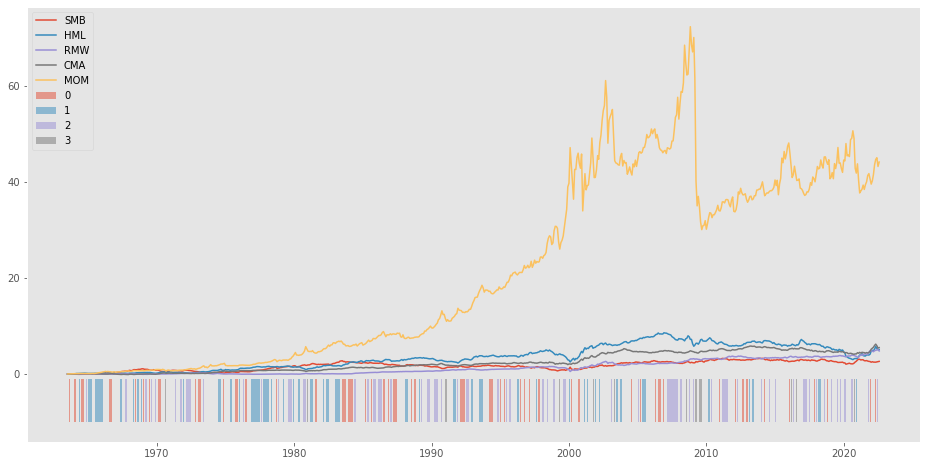

In [24]:
ymin, ymax = -10, -1
fix, ax = plt.subplots(figsize=(16, 8))
ax.plot((ff.drop("Label", axis=1) + 1).cumprod() - 1, label=ff.drop("Label", axis=1).columns.to_list())
ax.fill_between(x=ff.index, y1=ymin, y2=ymax, where=(ff["Label"] == 0), alpha=0.5, label="0")
ax.fill_between(x=ff.index, y1=ymin, y2=ymax, where=(ff["Label"] == 1), alpha=0.5, label="1")
ax.fill_between(x=ff.index, y1=ymin, y2=ymax, where=(ff["Label"] == 2), alpha=0.5, label="2")
ax.fill_between(x=ff.index, y1=ymin, y2=ymax, where=(ff["Label"] == 3), alpha=0.5, label="3")
ax.legend()
ax.grid()

<AxesSubplot:xlabel='Date'>

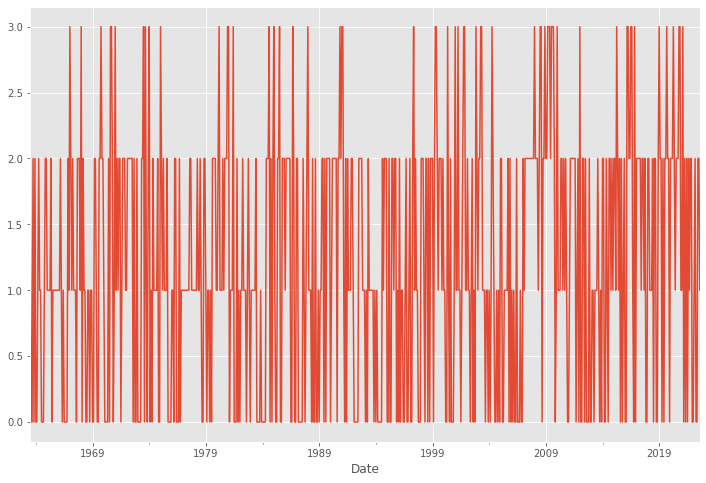

In [26]:
ff["Label"].plot(figsize=(12, 8))

## Starting from Indicators

Now that we have a few indicators, we can retry the same thing to generate labels.

In [8]:
data = pd.concat([cnfci(), csi(), slfsi(), cpi(), hys()], axis=1)
data.dropna(inplace=True)
data.head()

,NFCI,UMCSENT,STLFSI3,CPIAUCSL,BAMLH0A0HYM2
1996-12-01,-0.70521,1.157706,-0.0782,3.987469,3.13
1997-01-01,-0.71129,1.163680,-0.3270,3.994987,3.04
1997-02-01,-0.75876,1.191159,-0.6054,4.002506,2.73
1997-03-01,-0.71583,1.194743,-0.5146,4.005013,2.84
1997-04-01,-0.66695,1.211470,-0.3017,4.007519,2.94


In [9]:
# Use MoM change
data_mom = data.pct_change().dropna()
data_mom.head()

,NFCI,UMCSENT,STLFSI3,CPIAUCSL,BAMLH0A0HYM2
1997-01-01,0.008622,0.005160,3.181586,0.001886,-0.028754
1997-02-01,0.066738,0.023614,0.851376,0.001882,-0.101974
1997-03-01,-0.056579,0.003009,-0.149983,0.000626,0.040293
1997-04-01,-0.068284,0.014000,-0.413719,0.000626,0.035211
1997-05-01,0.001949,0.017751,0.055684,0.000000,-0.088435


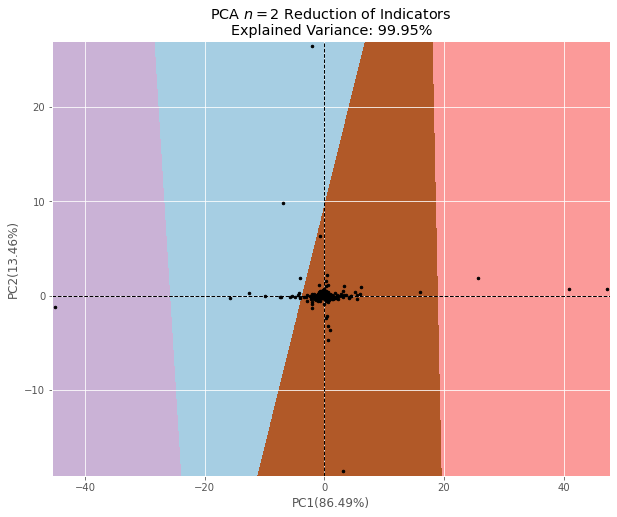

In [10]:
data_mom = data.pct_change().dropna()

pca = PCA(n_components=2)
red_mom = pca.fit_transform(data_mom)

kmeans = KMeans(n_clusters=4)
kmeans.fit(red_mom)

# Mesh step size, lower for better quality
h = 0.01

# Buffer for min/max
buff = 0.5

x_min, x_max = red_mom[:, 0].min() - buff, red_mom[:, 0].max() + buff
y_min, y_max = red_mom[:, 1].min() - buff, red_mom[:, 1].max() + buff
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure(figsize=(10,8))
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
plt.axhline(y=0, color="black", linewidth=1, linestyle="--")
plt.axvline(x=0, color="black", linewidth=1, linestyle="--")
plt.plot(red_mom[:, 0], red_mom[:, 1], "k.", markersize=5)
plt.xlabel(f"PC1({pca.explained_variance_ratio_[0]*100:.2f}%)")
plt.ylabel(f"PC2({pca.explained_variance_ratio_[1]*100:.2f}%)")
total_var = pca.explained_variance_ratio_.sum()*100
t = r"PCA $n=2$ Reduction of Indicators" + f"\nExplained Variance: {total_var:.2f}%"
plt.title(t)
plt.show()

In [11]:
data = pd.concat([cnfci(), csi(), slfsi(), cpi(), hys()], axis=1)
data_mom = data.pct_change().dropna()
# use less to see if we can get more info
data_mom = data_mom.loc["2010":]
for i in range(1, 6):

    print("*"*40)
    print(f"PCA {i}-components")

    pca = PCA(n_components=i)
    red_data_mom = pca.fit_transform(data_mom)
    print(f"Explained Variances: {pca.explained_variance_ratio_.round(2)}")
    print(f"Explained Variance: {sum(pca.explained_variance_ratio_)*100:.2f}%")
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(red_data_mom)

    ff = fama_french()

    data_mom["Label"] = kmeans.predict(red_data_mom)

    ff = pd.merge(ff.drop(["Mkt_RF", "RF"], axis=1), data_mom["Label"], left_index=True, right_index=True)

    res = (ff.groupby("Label").mean() * 100).style.highlight_max(color='green', axis=1).highlight_min(color='red', axis=1).format("{:.2f}")
    display(res)
    # display(ff.groupby("Label").describe().T) Too much info
    display(ff.groupby("Label").agg(['mean', 'var', 'count']).round(4))
    print(ff.groupby("Label").agg(['mean', 'var', 'count']).round(4).to_latex())
    print("*"*40)

****************************************
PCA 1-components
Explained Variances: [0.94]
Explained Variance: 93.89%


,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.10,0.03,0.20,0.07,0.05
1,-3.23,-4.76,0.55,-0.69,6.92
2,0.08,-0.08,0.49,0.81,1.00
3,-0.62,-1.31,0.30,-0.07,1.34


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0010  0.0006   128  0.0003  0.0009   128  0.0020  0.0004   128   
1     -0.0323     NaN     1 -0.0476     NaN     1  0.0055     NaN     1   
2      0.0008  0.0002    11 -0.0008  0.0007    11  0.0049  0.0006    11   
3     -0.0062  0.0014    12 -0.0131  0.0025    12  0.0030  0.0002    12   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0007  0.0004   128  0.0005  0.0012   128  
1     -0.0069     NaN     1  0.0692     NaN     1  
2      0.0081  0.0002    11  0.0100  0.0009    11  
3     -0.0007  0.0003    12  0.0134  0.0012    12

/var/folders/wh/63dtvrx97_31k2y9clt5xgwc0000gn/T/ipykernel_54360/1037130283.py:27: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{SMB} & \multicolumn{3}{l}{HML} & \multicolumn{3}{l}{RMW} & \multicolumn{3}{l}{CMA} & \multicolumn{3}{l}{MOM} \\
{} &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count \\
Label &         &         &       &         &         &       &         &         &       &         &         &       &         &         &       \\
\midrule
0     &  0.0010 &  0.0006 &   128 &  0.0003 &  0.0009 &   128 &  0.0020 &  0.0004 &   128 &  0.0007 &  0.0004 &   128 &  0.0005 &  0.0012 &   128 \\
1     & -0.0323 &     NaN &     1 & -0.0476 &     NaN &     1 &  0.0055 &     NaN &     1 & -0.0069 &     NaN &     1 &  0.0692 &     NaN &     1 \\
2     &  0.0008 &  0.0002 &    11 & -0.0008 &  0.0007 &    11 &  0.0049 &  0.0006 &    11 &  0.0081 &  0.0002 &    11 &  0.0100 &  0.0009 &    11 \\
3     & -0.0062 &  0.0014 &    12 & -0.0131 &  0.0025 &    12 &  0.003

,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.10,0.03,0.20,0.07,0.05
1,-3.23,-4.76,0.55,-0.69,6.92
2,-0.62,-1.31,0.30,-0.07,1.34
3,0.08,-0.08,0.49,0.81,1.00


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0010  0.0006   128  0.0003  0.0009   128  0.0020  0.0004   128   
1     -0.0323     NaN     1 -0.0476     NaN     1  0.0055     NaN     1   
2     -0.0062  0.0014    12 -0.0131  0.0025    12  0.0030  0.0002    12   
3      0.0008  0.0002    11 -0.0008  0.0007    11  0.0049  0.0006    11   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0007  0.0004   128  0.0005  0.0012   128  
1     -0.0069     NaN     1  0.0692     NaN     1  
2     -0.0007  0.0003    12  0.0134  0.0012    12  
3      0.0081  0.0002    11  0.0100  0.0009    11

/var/folders/wh/63dtvrx97_31k2y9clt5xgwc0000gn/T/ipykernel_54360/1037130283.py:27: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{SMB} & \multicolumn{3}{l}{HML} & \multicolumn{3}{l}{RMW} & \multicolumn{3}{l}{CMA} & \multicolumn{3}{l}{MOM} \\
{} &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count \\
Label &         &         &       &         &         &       &         &         &       &         &         &       &         &         &       \\
\midrule
0     &  0.0010 &  0.0006 &   128 &  0.0003 &  0.0009 &   128 &  0.0020 &  0.0004 &   128 &  0.0007 &  0.0004 &   128 &  0.0005 &  0.0012 &   128 \\
1     & -0.0323 &     NaN &     1 & -0.0476 &     NaN &     1 &  0.0055 &     NaN &     1 & -0.0069 &     NaN &     1 &  0.0692 &     NaN &     1 \\
2     & -0.0062 &  0.0014 &    12 & -0.0131 &  0.0025 &    12 &  0.0030 &  0.0002 &    12 & -0.0007 &  0.0003 &    12 &  0.0134 &  0.0012 &    12 \\
3     &  0.0008 &  0.0002 &    11 & -0.0008 &  0.0007 &    11 &  0.004

,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.10,0.03,0.20,0.07,0.05
1,-3.23,-4.76,0.55,-0.69,6.92
2,-0.62,-1.31,0.30,-0.07,1.34
3,0.08,-0.08,0.49,0.81,1.00


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0010  0.0006   128  0.0003  0.0009   128  0.0020  0.0004   128   
1     -0.0323     NaN     1 -0.0476     NaN     1  0.0055     NaN     1   
2     -0.0062  0.0014    12 -0.0131  0.0025    12  0.0030  0.0002    12   
3      0.0008  0.0002    11 -0.0008  0.0007    11  0.0049  0.0006    11   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0007  0.0004   128  0.0005  0.0012   128  
1     -0.0069     NaN     1  0.0692     NaN     1  
2     -0.0007  0.0003    12  0.0134  0.0012    12  
3      0.0081  0.0002    11  0.0100  0.0009    11

/var/folders/wh/63dtvrx97_31k2y9clt5xgwc0000gn/T/ipykernel_54360/1037130283.py:27: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{SMB} & \multicolumn{3}{l}{HML} & \multicolumn{3}{l}{RMW} & \multicolumn{3}{l}{CMA} & \multicolumn{3}{l}{MOM} \\
{} &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count \\
Label &         &         &       &         &         &       &         &         &       &         &         &       &         &         &       \\
\midrule
0     &  0.0010 &  0.0006 &   128 &  0.0003 &  0.0009 &   128 &  0.0020 &  0.0004 &   128 &  0.0007 &  0.0004 &   128 &  0.0005 &  0.0012 &   128 \\
1     & -0.0323 &     NaN &     1 & -0.0476 &     NaN &     1 &  0.0055 &     NaN &     1 & -0.0069 &     NaN &     1 &  0.0692 &     NaN &     1 \\
2     & -0.0062 &  0.0014 &    12 & -0.0131 &  0.0025 &    12 &  0.0030 &  0.0002 &    12 & -0.0007 &  0.0003 &    12 &  0.0134 &  0.0012 &    12 \\
3     &  0.0008 &  0.0002 &    11 & -0.0008 &  0.0007 &    11 &  0.004

,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.10,0.03,0.20,0.07,0.05
1,-3.23,-4.76,0.55,-0.69,6.92
2,-0.62,-1.31,0.30,-0.07,1.34
3,0.08,-0.08,0.49,0.81,1.00


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0010  0.0006   128  0.0003  0.0009   128  0.0020  0.0004   128   
1     -0.0323     NaN     1 -0.0476     NaN     1  0.0055     NaN     1   
2     -0.0062  0.0014    12 -0.0131  0.0025    12  0.0030  0.0002    12   
3      0.0008  0.0002    11 -0.0008  0.0007    11  0.0049  0.0006    11   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0007  0.0004   128  0.0005  0.0012   128  
1     -0.0069     NaN     1  0.0692     NaN     1  
2     -0.0007  0.0003    12  0.0134  0.0012    12  
3      0.0081  0.0002    11  0.0100  0.0009    11

/var/folders/wh/63dtvrx97_31k2y9clt5xgwc0000gn/T/ipykernel_54360/1037130283.py:27: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{SMB} & \multicolumn{3}{l}{HML} & \multicolumn{3}{l}{RMW} & \multicolumn{3}{l}{CMA} & \multicolumn{3}{l}{MOM} \\
{} &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count \\
Label &         &         &       &         &         &       &         &         &       &         &         &       &         &         &       \\
\midrule
0     &  0.0010 &  0.0006 &   128 &  0.0003 &  0.0009 &   128 &  0.0020 &  0.0004 &   128 &  0.0007 &  0.0004 &   128 &  0.0005 &  0.0012 &   128 \\
1     & -0.0323 &     NaN &     1 & -0.0476 &     NaN &     1 &  0.0055 &     NaN &     1 & -0.0069 &     NaN &     1 &  0.0692 &     NaN &     1 \\
2     & -0.0062 &  0.0014 &    12 & -0.0131 &  0.0025 &    12 &  0.0030 &  0.0002 &    12 & -0.0007 &  0.0003 &    12 &  0.0134 &  0.0012 &    12 \\
3     &  0.0008 &  0.0002 &    11 & -0.0008 &  0.0007 &    11 &  0.004

,SMB,HML,RMW,CMA,MOM
Label,,,,,
0,0.10,0.03,0.20,0.07,0.05
1,-3.23,-4.76,0.55,-0.69,6.92
2,-0.62,-1.31,0.30,-0.07,1.34
3,0.08,-0.08,0.49,0.81,1.00


SMB                   HML                   RMW                \
         mean     var count    mean     var count    mean     var count   
Label                                                                     
0      0.0010  0.0006   128  0.0003  0.0009   128  0.0020  0.0004   128   
1     -0.0323     NaN     1 -0.0476     NaN     1  0.0055     NaN     1   
2     -0.0062  0.0014    12 -0.0131  0.0025    12  0.0030  0.0002    12   
3      0.0008  0.0002    11 -0.0008  0.0007    11  0.0049  0.0006    11   

          CMA                   MOM                
         mean     var count    mean     var count  
Label                                              
0      0.0007  0.0004   128  0.0005  0.0012   128  
1     -0.0069     NaN     1  0.0692     NaN     1  
2     -0.0007  0.0003    12  0.0134  0.0012    12  
3      0.0081  0.0002    11  0.0100  0.0009    11

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{3}{l}{SMB} & \multicolumn{3}{l}{HML} & \multicolumn{3}{l}{RMW} & \multicolumn{3}{l}{CMA} & \multicolumn{3}{l}{MOM} \\
{} &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count &    mean &     var & count \\
Label &         &         &       &         &         &       &         &         &       &         &         &       &         &         &       \\
\midrule
0     &  0.0010 &  0.0006 &   128 &  0.0003 &  0.0009 &   128 &  0.0020 &  0.0004 &   128 &  0.0007 &  0.0004 &   128 &  0.0005 &  0.0012 &   128 \\
1     & -0.0323 &     NaN &     1 & -0.0476 &     NaN &     1 &  0.0055 &     NaN &     1 & -0.0069 &     NaN &     1 &  0.0692 &     NaN &     1 \\
2     & -0.0062 &  0.0014 &    12 & -0.0131 &  0.0025 &    12 &  0.0030 &  0.0002 &    12 & -0.0007 &  0.0003 &    12 &  0.0134 &  0.0012 &    12 \\
3     &  0.0008 &  0.0002 &    11 & -0.0008 &  0.0007 &    11 &  0.004

/var/folders/wh/63dtvrx97_31k2y9clt5xgwc0000gn/T/ipykernel_54360/1037130283.py:27: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.

